# Multiple Variables

In [1]:
# libraries
import numpy as np                   
import matplotlib.pyplot as plt  

import time
import sys

In [2]:
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

many pcles

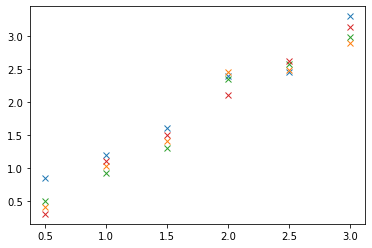

In [3]:
# Observe every 0.5 mins
time = torch.tensor([0.5,1.,1.5,2.,2.5,3.])
positions = torch.tensor([[0.84,1.2,1.6,2.4,2.45,3.3],
                         [0.4,1.02,1.4,2.45,2.48,2.9],
                         [0.5,0.92,1.3,2.35,2.58,2.99],
                         [0.3,1.1,1.5,2.1,2.62,3.14]])
for i in range(4):
    plt.plot(time.numpy(),positions[i].numpy(),'x');


In [4]:
beta = 1.5
sd = 0.3
time = torch.tensor([0.5,1.,1.5,2.,2.5,3.])
positions = torch.zeros((10,len(time)))
for i in range(10):
    positions[i,:] = time*pyro.sample(str(i),dist.Normal(beta,sd))


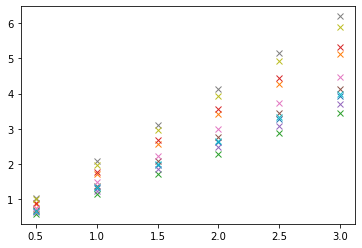

In [5]:
for i in range(10):
    plt.plot(time.numpy(),positions[i].numpy(),'x');

In [6]:
def model(positions,time):
    """Returns observation given time and latent variable speed"""
    speed_mean = pyro.sample("speed_mean",dist.Normal(1.,1.))
    speed_sd = pyro.sample("speed_sd",dist.Normal(0.5,0.25))
    for i in pyro.plate("particle_loop",positions.shape[0]):
        speed = pyro.sample("speed_{}".format(str(i)),
                    dist.Normal(speed_mean,speed_sd))
        for t in range(len(time)):
            pyro.sample("position_{}{}".format(str(i),str(t)),
                    dist.Normal(speed*time[t],0.1),
                    obs=positions[i,t])
        

In [7]:
model(positions,time)

In [8]:
from torch.distributions import constraints
def guide(position,time):
    mu = pyro.param("mu",torch.tensor(1.5))
    sd = pyro.param("sd",torch.tensor(0.5),constraint=constraints.positive)
    speed_mean = pyro.sample("speed_mean",dist.Delta(mu))
    speed_sd = pyro.sample("speed_sd",dist.Delta(sd))
    for i in pyro.plate("particle_loop",positions.shape[0]):
        speed = pyro.sample("speed_{}".format(str(i)),
                    dist.Normal(speed_mean,speed_sd))
        

In [11]:
param_store = pyro.get_param_store()

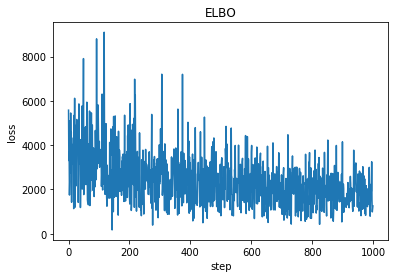

In [12]:
from pyro.optim import Adam
#pyro.clear_param_store()
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
svi = pyro.infer.SVI(model=model, 
                     guide=guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO()
                     )

num_steps = 1000
# Save all parameters and losses
#params = np.zeros((num_steps,len(param_names)))
losses = np.zeros(num_steps)
mus = np.zeros(num_steps)
sds = np.zeros(num_steps)
for t in range(num_steps):
    losses[t] = (svi.step(positions,time))
    mus[t] = param_store["mu"]
    sds[t] = param_store["sd"]    


plt.plot(losses);
plt.title("ELBO");
plt.xlabel("step");
plt.ylabel("loss");

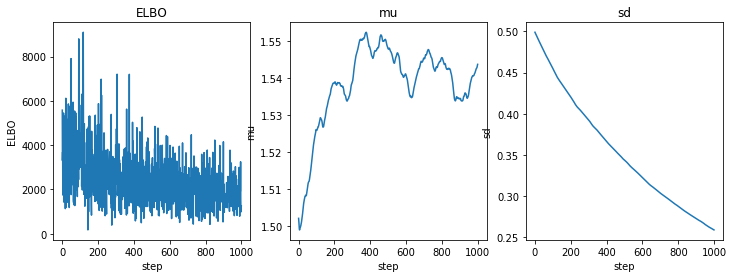

In [13]:
fig = plt.figure(figsize=(12,4))
ax0 = plt.subplot2grid((1, 3), (0, 0));
ax0.plot(losses);
plt.title("ELBO");
plt.xlabel("step");
plt.ylabel("ELBO");
ax1 = plt.subplot2grid((1, 3), (0, 1));
ax1.plot(mus);
plt.title("mu");
plt.xlabel("step");
plt.ylabel("mu");
ax2 = plt.subplot2grid((1, 3), (0, 2));
ax2.plot(sds);
plt.title("sd");
plt.xlabel("step");
plt.ylabel("sd");

In [5]:
pyro.clear_param_store()
def propagate(x0,guess,time=torch.tensor(10.),np=20,plot_wave=False):
    """ what are input params  """
    # each particle has an independent initial position and speed 
    position_init,speed,position_obs = [],[],[]
    for i in pyro.plate("h_loop",np):
        position_init_i = (pyro.sample("position_init_{}".format(str(i)),
                                    dist.Normal(x0, 0.6)))
        speed_i = (pyro.sample("speed_{}".format(str(i)),
                            dist.Normal(guess, 0.25)))
        
        # What we observe
        position_final = position_init_i + speed_i * time
        # final position is observed with a bit of noise
        position_obs_i = (pyro.sample("position_obs_{}".format(str(i)),
                                        dist.Normal(position_final,0.1)))
        
        position_init.append(position_init_i.item())
        speed.append(speed_i.item())
        position_obs.append(position_obs_i.item())
    return(speed,position_init,position_obs)



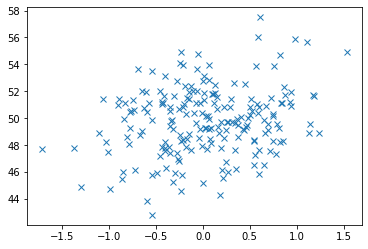

In [6]:
speed,position_init,position_obs = propagate(torch.tensor(0.),torch.tensor(5.0),np=200)
plt.plot(position_init,position_obs,'x');

We observe a  few points.

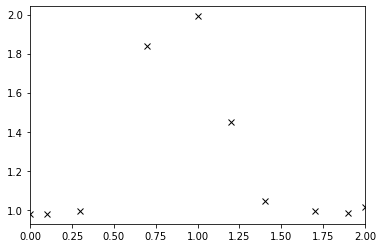

In [214]:
observed_h = [1.7982, 1.8927, 1.9496, 1.9769, 1.9807, 
              1.9590, 1.9026, 1.8027, 1.6616, 1.4969]
observed_inds = range(25,36)

observed_speed = speed
# Pick some random points that we observe
observed_inds = np.random.choice(len(h),size=10,replace=False)
# TEMPORARILY FIX THIS
observed_inds = [3, 20, 14, 10,  1, 17,  7, 12,  0, 19]
observed_h = h[observed_inds]

# Put into data dictionary with named labels
keys = ["h_{}".format(str(i)) for i in observed_inds]
data = dict(zip(keys, observed_h))

# Plot
plt.plot(np.linspace(0,2,nx)[observed_inds],observed_h.numpy(),'kx');
plt.axis(xmin=0.,xmax=2);

In [215]:
print(observed_inds)

[3, 20, 14, 10, 1, 17, 7, 12, 0, 19]


In [216]:
print(data)

{'h_3': tensor(0.9914), 'h_20': tensor(1.0158), 'h_14': tensor(1.0438), 'h_10': tensor(1.9912), 'h_1': tensor(0.9789), 'h_17': tensor(0.9946), 'h_7': tensor(1.8366), 'h_12': tensor(1.4506), 'h_0': tensor(0.9787), 'h_19': tensor(0.9841)}


In [217]:
observed_speed

tensor(0.5792)

In [218]:
conditioned_wave = pyro.condition(wave, data=data)

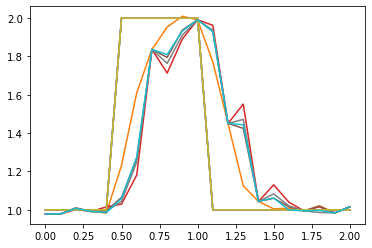

In [219]:
# Check this gives conditioned values fixed
for i in range(5):
    u_observed = conditioned_wave(1.,plot_wave=True)

What if we condition on wave output, can we get the wave speed needed to get this output (using fixed wave speed from before, the correct value should be 0.5)?

Now create the guide, with parameters that should move us towards observed values of the wave.

In [201]:
from torch.distributions import constraints

def wave_parametrized_guide(guess,plot_wave=False):
    nx = 21  
    # want to infer speed, and h_i at all values that we don't know them at
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), 
                   constraint=constraints.positive)

    speed = pyro.sample("speed", dist.Normal(a,b))
    h = torch.zeros(nx)
    
    # TEMPORARILY FIX OBSERVED INDICES
    #observed_inds = [3, 20, 14, 10,  1, 17,  7, 12,  0, 19]

    for i in range(nx):
        # TEMP
        if (i in observed_inds):
            continue
        # Need to sample from variables we don't have observations for
        # This is probably the worst way to do it- just sampling at random from
        # A normal distribution and then constraining parameters. We could add
        # something that learns from the observartions we do have (eg GP) to do this
        
        c_i = pyro.param("c_{}".format(i),torch.tensor(1.))
        d_i = pyro.param("d_{}".format(i), torch.tensor(1.),
                         constraint=constraints.positive)

        h[i] = (pyro.sample("h_{}".format(str(i)),dist.Normal(c_i,d_i)) )
    
    if plot_wave:
        h = torch.detach(h)
        plt.plot(np.linspace(0,2,nx),h.numpy(),'bx')
    
    return(speed,h)



In [202]:
pyro.clear_param_store()
wave_parametrized_guide(guess,plot_wave=True)
param_names = list(pyro.get_param_store().get_all_param_names())
print(param_names)

TypeError: wave_parametrized_guide() missing 1 required positional argument: 'guess'

In [203]:
#pyro.clear_param_store()
wave_parametrized_guide(observed_inds,plot_wave=True)

RuntimeError: only Tensors of floating point dtype can require gradients

In [204]:
import pyro.poutine
traced=pyro.poutine.trace(wave_parametrized_guide)

In [205]:
param_names = list(pyro.get_param_store().get_all_param_names())

In [206]:
print(param_names)
print(len(param_names))

[]
0


In [209]:
from pyro.optim import Adam
#pyro.clear_param_store()
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
svi = pyro.infer.SVI(model=conditioned_wave, 
                     guide=wave_parametrized_guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO()
                     )

num_steps = 10
# Save all parameters and losses
params = np.zeros((num_steps,len(param_names)))
losses = np.zeros(num_steps)

for t in range(num_steps):
    losses[t] = (svi.step(guess=1.))
    params[t,:] = [pyro.param(param_names[i]).item() for i in range(len(param_names))]
    


plt.plot(losses);
plt.title("ELBO");
plt.xlabel("step");
plt.ylabel("loss");


TypeError: wave() got an unexpected keyword argument 'guess'

a =  1.0036689043045044
b =  0.9918873906135559


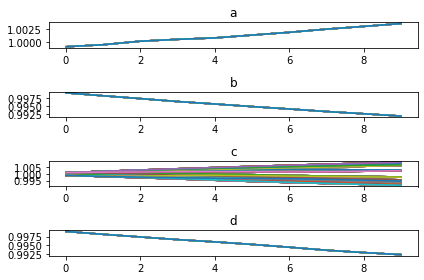

In [127]:
print("a = ",pyro.param("a").item())
print("b = ", pyro.param("b").item())

fig = plt.figure()
ax1 = plt.subplot2grid((4, 1), (0, 0));
for i in range(nx):
    ax1.plot(params[:,0])
plt.title('a');

ax2 = plt.subplot2grid((4, 1), (1, 0));
for i in range(nx):
    ax2.plot(params[:,1])
plt.title('b');

ax3 = plt.subplot2grid((4, 1), (2, 0));
for i in range(nx):
    ax3.plot(params[:,2:(nx+2)])
plt.title('c');

ax4 = plt.subplot2grid((4, 1), (3, 0));
for i in range(nx):
    ax4.plot(params[:,(nx+2):])
plt.title('d');
plt.tight_layout();

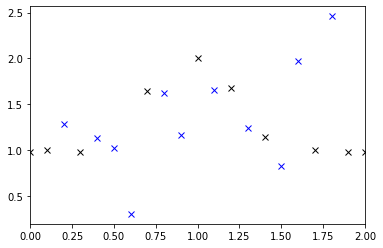

In [134]:
speed,h=wave_parametrized_guide()
plt.plot(np.linspace(0,2,nx)[observed_inds],
         observed_h.numpy(),'kx');
not_observed_inds = [i for i in range(nx) 
                     if i not in observed_inds]
plt.plot(np.linspace(0,2,nx)[not_observed_inds],
         h.detach().numpy()[not_observed_inds],'bx');
plt.axis(xmin=0.,xmax=2);

In [135]:
param_store = pyro.get_param_store()
print(param_store.keys())
print(param_store['a'])
print(param_store['b'])

dict_keys(['a', 'b', 'c_2', 'd_2', 'c_4', 'd_4', 'c_5', 'd_5', 'c_6', 'd_6', 'c_8', 'd_8', 'c_9', 'd_9', 'c_11', 'd_11', 'c_13', 'd_13', 'c_15', 'd_15', 'c_16', 'd_16', 'c_18', 'd_18'])
tensor(1.0168, requires_grad=True)
tensor(0.9744, grad_fn=<AddBackward0>)


In [136]:
observed_speed

tensor(0.8596)

In [89]:
speed,h=wave_parametrized_guide()

## What if we have many observations of many particles


example taken from https://forum.pyro.ai/t/how-to-use-pyro-condition-with-pyro-iarange-on-iid-data-points/349


In [57]:
# hyperparameter for prior
loc_loc_0 = 30
loc_scale_0 = 10

def model(data):
    # prior of loc
    z_loc = pyro.sample('z_loc', dist.Normal(loc=loc_loc_0, scale=loc_scale_0))   
    with pyro.iarange('observe_data', size=len(data)) as ind:
        pyro.sample('obs', dist.Normal(loc=z_loc, scale=loc_scale_0),
                obs=data.index_select(0, ind))
        
def guide(data):
    # register the one variational parameters with Pyro.
    variational_loc = pyro.param("variational_loc", torch.tensor(60.0))
    pyro.sample('z_loc', dist.Normal(loc=variational_loc, scale=loc_scale_0))


In [58]:
data = torch.tensor(np.random.normal(45.,10.,(100)),dtype=torch.float)

(array([ 2.,  3.,  8., 18., 24., 23., 13.,  8.,  0.,  1.]),
 array([15.270977, 21.594679, 27.918379, 34.24208 , 40.56578 , 46.88948 ,
        53.213184, 59.536884, 65.86059 , 72.18429 , 78.50799 ],
       dtype=float32),
 <a list of 10 Patch objects>)

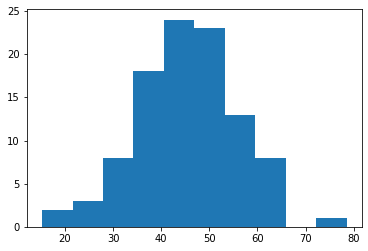

In [59]:
plt.hist(data)


In [67]:
from pyro.optim import Adam
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
#pyro.clear_param_store()
svi = pyro.infer.SVI(model=model, 
                     guide=guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO())

losses, mu = [], []
num_steps = 100000
for t in range(num_steps):
    losses.append(svi.step(data))
    mu.append(pyro.param("variational_loc").item())


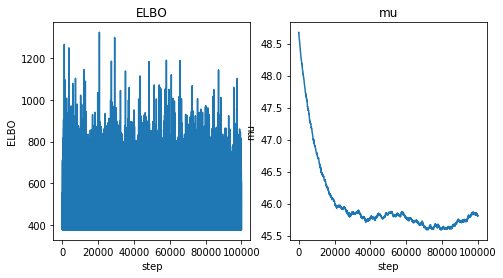

In [68]:
fig = plt.figure(figsize=(12,4))
ax0 = plt.subplot2grid((1, 3), (0, 0));
ax0.plot(losses);
plt.title("ELBO");
plt.xlabel("step");
plt.ylabel("ELBO");
ax1 = plt.subplot2grid((1, 3), (0, 1));
ax1.plot(mu);
plt.title("mu");
plt.xlabel("step");
plt.ylabel("mu");


In [75]:
def model(N):
    # prior of loc
    z_loc = pyro.sample('z_loc', dist.Normal(loc=loc_loc_0, scale=loc_scale_0))   
    with pyro.iarange('observe_data', N):
        pyro.sample('obs', dist.Normal(loc=z_loc, scale=loc_scale_0))

def conditioned_model(data):
    return pyro.condition(model, data={"obs": data})(len(data))


In [78]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_model, 
                     guide=guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO())

losses, mu = [], []
num_steps = 100000
for t in range(num_steps):
    losses.append(svi.step(data))
    mu.append(pyro.param("variational_loc").item())



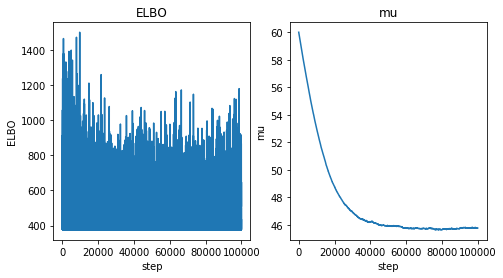

In [77]:
fig = plt.figure(figsize=(12,4))
ax0 = plt.subplot2grid((1, 3), (0, 0));
ax0.plot(losses);
plt.title("ELBO");
plt.xlabel("step");
plt.ylabel("ELBO");
ax1 = plt.subplot2grid((1, 3), (0, 1));
ax1.plot(mu);
plt.title("mu");
plt.xlabel("step");
plt.ylabel("mu");

In [142]:
def model(N,guess=1.,time=5.):
    """ Parameters:
    guess = the user's guess for the speed
    position_0 = initial position 
    time = length of time before observing """
    # get pyro distribution of speed (unknown)
    speed_loc = pyro.sample("speed_loc", dist.Normal(guess, 0.25))
    speed_scale = pyro.sample("speed_scale", dist.Normal(0.5, 0.25))
    position_obs = torch.zeros(N)
    with pyro.iarange("observe_data", N) as i:
        position_obs[i] = pyro.sample("obs", 
                                      dist.Normal(loc=speed_loc*time,
                                                  scale=speed_scale))
    return position_obs

def conditioned_model(data,guess=1.,time=5.):
    return pyro.condition(model, data={"obs": data})(len(data),guess,time)

def guide(data,guess=1.,time=5.):
    # register the one variational parameters with Pyro.
    variational_loc = pyro.param("variational_loc", torch.tensor(guess))
    variational_scale = pyro.param("variational_scale", torch.tensor(guess),
                                  constraint=constraints.positive)


    pyro.sample('speed_loc', dist.Normal(loc=variational_loc, scale=0.25))
    pyro.sample("speed_scale", dist.Normal(loc=variational_scale, scale=0.25))


    

In [143]:
data = torch.tensor(np.random.normal(3.,1.,(100)),dtype=torch.float)

<Figure size 432x288 with 0 Axes>

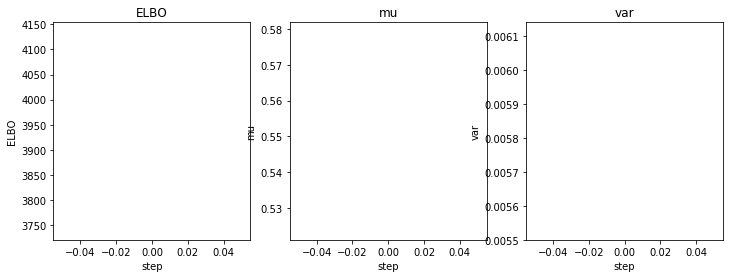

/anaconda3/envs/infolab/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/anaconda3/envs/infolab/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/anaconda3/envs/infolab/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/anaconda3/envs/infolab/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/anaconda3/envs/infolab/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/anaconda3/envs/infolab/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/anaconda3/envs/infolab/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan

KeyboardInterrupt: 

In [144]:
#pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_model, 
                     guide=guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO())

losses, mu,var = [], [],[]
num_steps = 10000
for t in range(num_steps):
    losses.append(svi.step(data))
    mu.append(pyro.param("variational_loc").item())
    var.append(pyro.param("variational_scale").item())
    
    if t%1000 == 0:
        plt.clf()
        fig = plt.figure(figsize=(12,4));
        ax0 = plt.subplot2grid((1, 3), (0, 0));
        ax0.plot(losses);
        plt.title("ELBO");
        plt.xlabel("step");
        plt.ylabel("ELBO");
        ax1 = plt.subplot2grid((1, 3), (0, 1));
        ax1.plot(mu);
        plt.title("mu");
        plt.xlabel("step");
        plt.ylabel("mu");
        ax2 = plt.subplot2grid((1, 3), (0, 2));
        ax2.plot(var);
        plt.title("var");
        plt.xlabel("step");
        plt.ylabel("var");
        plt.show();





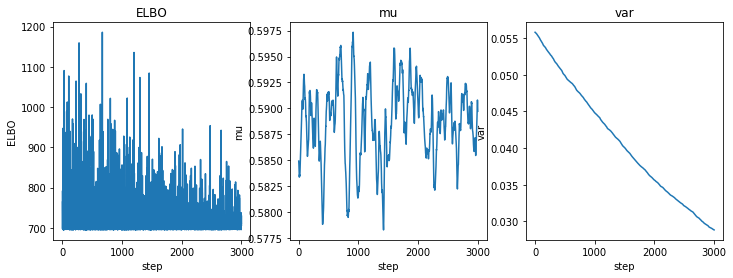

In [136]:
fig = plt.figure(figsize=(12,4))
ax0 = plt.subplot2grid((1, 3), (0, 0));
ax0.plot(losses);
plt.title("ELBO");
plt.xlabel("step");
plt.ylabel("ELBO");
ax1 = plt.subplot2grid((1, 3), (0, 1));
ax1.plot(mu);
plt.title("mu");
plt.xlabel("step");
plt.ylabel("mu");
ax2 = plt.subplot2grid((1, 3), (0, 2));
ax2.plot(var);
plt.title("var");
plt.xlabel("step");
plt.ylabel("var");

In [134]:
3/5.

0.6